In [ ]:
# -*- coding: utf-8 -*-
# 
# Final project to course Artificial Neural Networks (Spring 2020)
# 
# Author: Imrich Kascak
# E-mail: er1602@edu.hmu.gr
# 
# Used dataset: Haberman's Survival Data Set
# URL of dataset: https://archive.ics.uci.edu/ml/datasets/Haberman%27s+Survival
# 
# =================================================================================

In [22]:
import numpy as np
import pylab as pl
import pandas as pd
import neurolab as nl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set()

import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
# Step 1 - Load data
data = pd.DataFrame(pd.read_csv(os.getcwd() + '/data/Haberman\'s Survival.data', header=None, names=['age', 'year_operation', 'positive_axillary_nodes', 'survived_after_5_years']))
X = (data).to_numpy()[:,:3]
T = (data).to_numpy()[:,3]

# Target transform
# class 1 --> 0 -- survived 5 years and longer
# class 2 --> 1 -- died within 5 years
val_map = {1: [0], 2: [1]}
T = np.array([val_map[t] for t in T])
data['survived_after_5_years'] = data['survived_after_5_years'].map({1: 0, 2: 1})

In [ ]:
# Visualization of input data
sns.pairplot(data, hue='survived_after_5_years', size=4)
plt.show()

In [ ]:
# Step 3 - Pre-process data using given formula
X_n = np.empty([306,3])
for i in range(3):
    Xmin = np.amin(X[:,i])
    Xmax = np.amax(X[:,i])
    X_n[:,i] = - ((X[:,i] - Xmin) / (Xmax - Xmin)) + 1

# Pre-process data using MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

In [ ]:
# Choose value to further processing X_n / X_scaled
X_process = X_scaled

# Setting values
train_size = 0.90
test_size = 0.10

hidden_layer = 4
output_layer = 1
epochs = 50
lr = 0.4
goal = 1e-5

In [ ]:
# Step 3 - Split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_process, T, train_size=train_size, test_size=test_size)

# Step 4 - Create a neural network (Multilayer feed forward perceptron)
net = nl.net.newff(nl.tool.minmax(X_process),[hidden_layer,output_layer])

# Change the transfer function for the output layer
net.layers[-1].transf = nl.trans.LogSig() # output layer
net.layers[0].transf = nl.trans.LogSig() # hidden layer
net.layers[1].transf = nl.trans.LogSig() # hidden layer

# Train the network
error = net.trainf = nl.train.train_rprop(net, X_train, y_train, epochs=epochs, show=10, lr=lr, goal=goal)

In [ ]:
# Plot error
plt.plot(error)
plt.xlabel('Epoch number')
plt.ylabel('Train error')
plt.grid()
plt.show()

In [ ]:
# Simulate network
out = net.sim(X_test)
out = np.around(out)

# Compare the results
print(np.array_equal(out, y_test))
accuracy = np.mean(out == y_test)
accuracy_percentage = round(accuracy * 100, 2)
print(accuracy)
print(accuracy_percentage, '%')

In [ ]:
# Compare the results
plt.figure(1)
plt.subplot(2,1,1)
plt.plot(out,'ro')
plt.ylabel('Class')
plt.xlabel('Sample')
plt.title('Simulation output')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(y_test,'ro')
plt.ylabel('Class')
plt.xlabel('Sample')
plt.title('y_test')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Compare 10 random patterns
length = 10
chosen_out = []
chosen_y_test = []
rand_numbers = np.sort(np.random.randint(len(y_test), size=(length)))
for i in rand_numbers:
    chosen_out.append(out[i])
    chosen_y_test.append(y_test[i])

plt.figure(1)
plt.subplot(2,1,1)
# create an index for each tick position
xi = list(range(length))
plt.plot(chosen_out,'ro')
plt.xticks(xi, rand_numbers)
plt.ylabel('Class')
plt.xlabel('Sample')
plt.title('Simulation output')
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(chosen_y_test,'ro')
plt.xticks(xi, rand_numbers)
plt.ylabel('Class')
plt.xlabel('Sample')
plt.title('y_test')
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Summary of all split rates (info in documentation)
results = [74.18, 74.39, 76.36, 78.23, 82.26]
split_rates = ['50:50', '60:40', '70:30', '80:20', '90:10']
xi = list(range(5))
plt.plot(results, marker='o', linestyle='--', color='darkgreen', label='Mean value')
plt.xticks(xi, split_rates)
plt.ylabel('Accuracy (%)')
plt.xlabel('Split rate')
plt.title('Summary')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# 
# 
# 
# 
# 
# 
# Kohonen network (unsupervised learning)
# 
# 
# 
# 
# 
# 

In [3]:
# Step 1 - Load data
data = pd.DataFrame(pd.read_csv(os.getcwd() + '/data/Haberman\'s Survival.data', header=None, names=['age', 'year_operation', 'positive_axillary_nodes', 'survived_after_5_years']))
X = (data).to_numpy()[:,:3]

In [4]:
# Scale the data [0,1]
min_max_scaler = preprocessing.MinMaxScaler()
X_k = min_max_scaler.fit_transform(X)

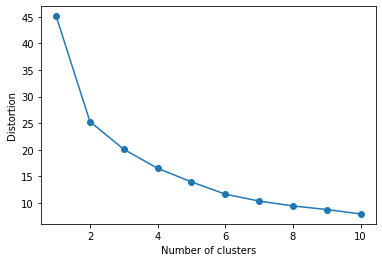

In [5]:
# Clustering data - calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
    km.fit(X_k)
    distortions.append(km.inertia_)

plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [12]:
# Create a Kohonen neural network
koh_net = nl.net.newc(nl.tool.minmax(X_k), 2)

# Train the network with rule: Winner Take All algoritm (WTA)
error = koh_net.trainf = nl.train.train_wta(koh_net, X_k, epochs=100, show=10)

Epoch: 10; Error: 122.92320714549778;
Epoch: 20; Error: 123.10980580153085;
Epoch: 30; Error: 123.16342747593153;
Epoch: 40; Error: 123.16340620354373;
Epoch: 50; Error: 123.16340562685465;
Epoch: 60; Error: 123.16340561370578;
Epoch: 70; Error: 123.16340561351436;
Epoch: 80; Error: 123.16340561351205;
Epoch: 90; Error: 123.16340561351204;
Epoch: 100; Error: 123.16340561351204;
The maximum number of train epochs is reached


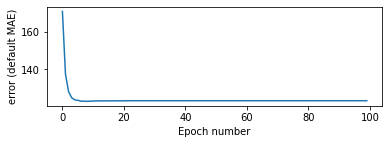

In [13]:
# Plot error
plt.figure(1)
plt.title('Classification Problem')
plt.subplot(2,1,1)
plt.plot(error)
plt.xlabel('Epoch number')
plt.ylabel('error (default MAE)')
w = koh_net.layers[0].np['w']

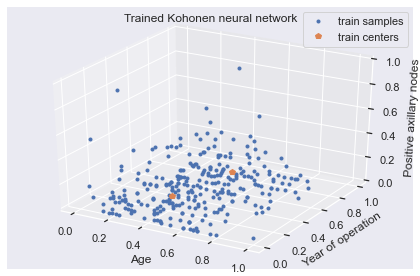

In [23]:
# Plot results
fig = plt.figure(1)
ax = fig.add_subplot(111, projection='3d')
ax.plot(X_k[:,0], X_k[:,1], X_k[:,2], '.')
ax.plot(w[:,0], w[:,1], w[:,2], 'p')
ax.set_title('Trained Kohonen neural network')
ax.set_xlabel('Age')
ax.set_ylabel('Year of operation')
ax.set_zlabel('Positive axillary nodes')
plt.legend(['train samples', 'train centers'])
plt.tight_layout()
plt.show()